In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary

import numpy as np

import matplotlib.pyplot as plt

import os


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name() if torch.cuda.is_available() else 'cpu')

NVIDIA GeForce RTX 3050 6GB Laptop GPU


# Simulation Config


In [12]:
# Spatial Domain
xmin, xmax = 0, 2*np.pi  # Domain limits
Nx = 512                        # Number of Spatial points
L = abs(xmax - xmin)            # Domain Length
dx = L / (Nx - 1)               # Cell width

_x = torch.linspace(xmin, xmax, Nx, requires_grad=True).view(-1, 1).to(device)

# Temporal Domain
Tf = 2.0                # Final time
dt = 0.01               # Time step
Nt = int(Tf / dt) + 1   # Number of temporal points

_t = torch.linspace(0, Tf, Nt, requires_grad=True).view(-1, 1).to(device)

# Mesh
t_mesh, x_mesh = torch.meshgrid(_t.squeeze(1), _x.squeeze(1), indexing='ij')
x, t = x_mesh.reshape(-1, 1), t_mesh.reshape(-1, 1)


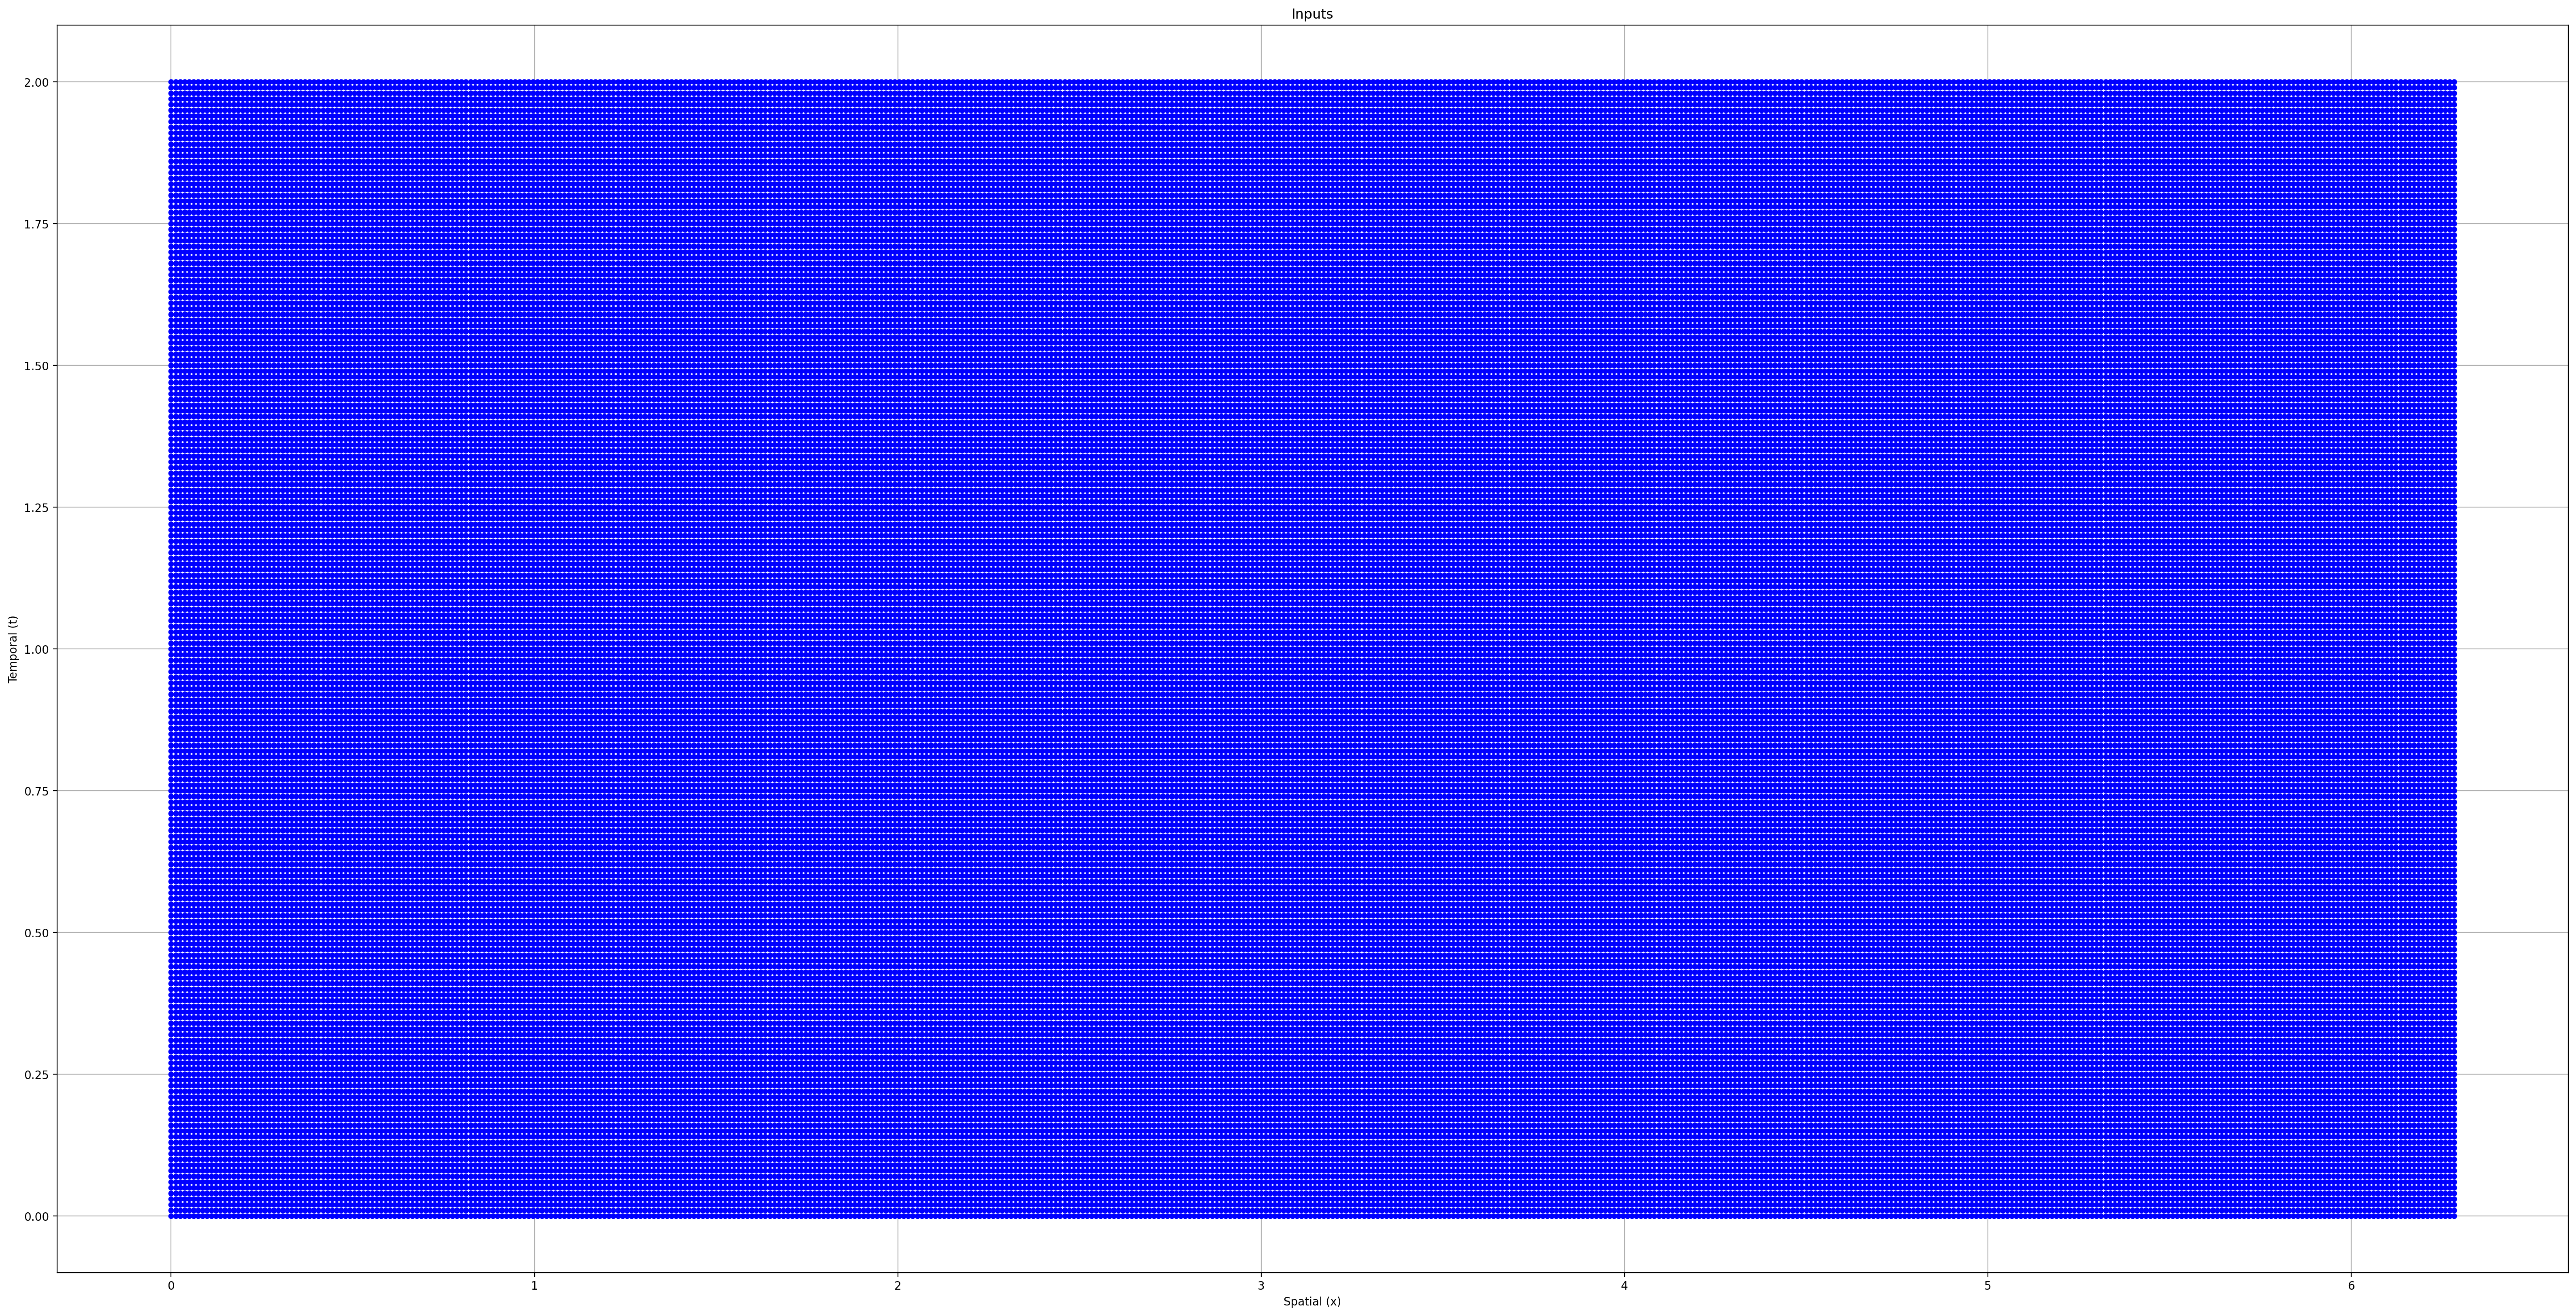

In [13]:
# x_np = _x.detach().cpu().numpy()
# t_np = _t.detach().cpu().numpy()

plt.figure(figsize=(40, 20), dpi=200)
plt.plot(x_mesh.detach().cpu().numpy(), t_mesh.detach().cpu().numpy(), 'bo', markersize=4)
# plt.plot(x_np, np.zeros_like(x_np), label='x (Spatial)', marker='o', markerfacecolor='none')
# plt.plot(np.zeros_like(t_np), t_np, label='t (Temporal)', marker='x', color='orange')
plt.title('Inputs')
plt.xlabel('Spatial (x)')
plt.ylabel('Temporal (t)')
plt.grid(True, linestyle='-', alpha=1)
plt.show()

# PDE Setup

In [14]:
def initialise(x_tensor, condition):
    """
    Initialize the solution based on different initial conditions.
    
    Args:-
    - x_tensor: Tensor of Nx spatial points.
    - condition: Integer representing the type of initial condition to use.
    
    Returns:
    - u_0: Initial condition evaluated at the spatial points x.
    """
    if condition == 1:
        # Singular initial data
        print("Initial Condition: 1/4 * ((x_j >= 3*pi/4) && (x_j <= 5*pi/4)) + 1/2 * ((x_j >= pi/2) && (x_j <= 3*pi/2)")
        u_0 = 0.25 * ((x_tensor >= 3*np.pi/4) & (x_tensor <= 5*np.pi/4)) + \
              0.5 * ((x_tensor >= np.pi/2) & (x_tensor <= 3*np.pi/2))
    elif condition == 2:
        # Polynomial initial data
        print("Initial Condition: (6/pi^3) * (3*pi/2 - x) * (x - pi/2), if pi/2 <= x < 3*pi/2; 0 otherwise.")

        u_0 = torch.where((x_tensor >= np.pi/2) & (x_tensor < 3*np.pi/2),
                          (6/np.pi**3) * (3*np.pi/2 - x_tensor) * (x_tensor - np.pi/2),
                          torch.zeros_like(x_tensor))
    elif condition == 3:
        # Sine initial data
        print("Initial Condition: sin(x)")
        u_0 = -torch.sin(x_tensor)

    return u_0


# Fne Mesh / Exact Solution
ex_data_exists = os.path.getsize("u_ex.txt") > 0
if ex_data_exists:
    uex = np.loadtxt('u_ex.txt')


# PDE Flux
def flux(u):
    return -torch.real(torch.fft.ifft(torch.fft.fft(torch.sin(_x.repeat(_t.shape))) * torch.fft.fft(u))) * u 
    # return -K * torch.sin(x) * dx * u


# Initial data
u_0 = initialise(_x, 2).to(device)

Initial Condition: (6/pi^3) * (3*pi/2 - x) * (x - pi/2), if pi/2 <= x < 3*pi/2; 0 otherwise.


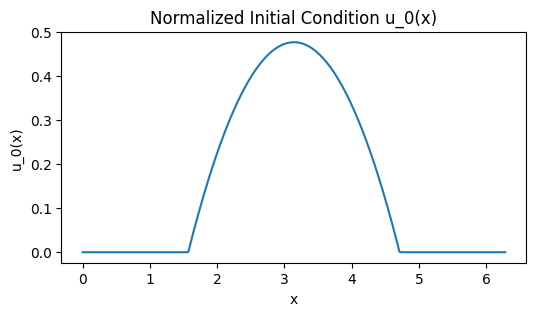

In [15]:
plt.figure(figsize=(6, 3))
plt.plot(_x.detach().cpu().numpy(), u_0.detach().cpu().numpy(), label='Initial Condition')
plt.title('Normalized Initial Condition u_0(x)')
plt.xlabel('x')
plt.ylabel('u_0(x)')
plt.show()

# Helper

In [16]:
def plot():
    """
    Plot the sim_data from the PINN model and the exact solution.
    
    Args:-
    - sim_data: Predicted values for each time step (2D array: time x space).
    - ex_data: Optional exact solution data (same shape as sim_data) | Taken from extremely fine mesh using FVM
    """
    sim_data = np.loadtxt('simulation_data.txt')

    x = np.linspace(xmin, xmax, Nx)
    
    time_steps = len(sim_data)
    Dt = Tf / (time_steps-1)
    
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'$\mu(\theta)$')

    for _, t in enumerate([0, 16, 32, 64, 128, 200]):
        plt.clf()
        plt.title(f'PINN Simulation after Time Step {t}, t={round(t*Dt, 3)}')

        # Exact Solution
        if ex_data_exists and (t == Nt-1 or t == 0):
            _t = -1 if t == Nt-1 else 0
            plt.plot(x, uex[t, :], linestyle=":", marker="o", markersize=1, markerfacecolor='none', label='Exact Solution')
        # PINN Solution
        plt.plot(x, sim_data[t, :], linestyle=":", marker="x", markersize=3, label='PINN Prediction')
        
        plt.savefig(f'steps/{t}.png', bbox_inches='tight')
        plt.legend()
        plt.draw()
        plt.pause(0.08)

    plt.show()


def write_data(file, u):
    """
    Write the simulation results to a file.
    
    Args:-
    - filename: The file object to write to.
    - u: The array of predicted values (1D array for a single time step).
    """
    file.write(" ".join(map(str, u)) + "\n")


def get_param():
    """
    Print the simulation parameters relevant to the PINN model.
    """
    print("\nPINN Simulation Parameters\n")
    print(f"Domain Limits (xmin, xmax): {xmin} , {xmax}")
    print(f"Domain Length (L): {L}")
    print(f"Number of Spatial Points (Nx): {Nx}")
    print(f"Cell Width (dx): {dx}\n")
    print(f"Final Time (Tf): {Tf}\n")
    print(f"Time Step (dt): {dt}")
    print(f"Number of Time Steps (Nt): {Nt}\n")


# Network Architecture
### Simple FeedForward Neural Network

-> 1 input layer

-> 4 fully connected hidden layers; 64 neurons each

-> 1 output layer

In [17]:
class PINN(nn.Module):
    def __init__(self, layers, units):
        """
        Initialise the PINN model.
        
        Args:-
        - layers: number of hidden layers
        - units: number of neurons in each hidden layer 
        """
        super(PINN, self).__init__()
        
        self.layers = nn.ModuleList()
        
        self.layers.append(nn.Linear(2, units)) # input layer ~> {x, t}
        for _ in range(layers): 
            self.layers.append(nn.Linear(units, units))   # hidden layers
        self.layers.append(nn.Linear(units, 1)) # output layer ~> u(x, t)

        
    def forward(self, x_tensor, t_tensor):
        """
        Forward pass through the network. It takes in time `t` and space `x` and outputs the solution `u(x, t)`.
        
        Args:-
        - x_tensor: Mesh of Nt*Nx space values 
        - t_tensor: Mesh of Nt*Nx temporal values
        
        Returns:
        - u: Neural network output representing the function `u(x, t)`.
        """
        t_ = t_tensor
        x_ = x_tensor
        
        inputs = torch.cat([t_, x_], dim=1)
        for layer in self.layers[:-1]:
            inputs = torch.sin(layer(inputs))      # sine activation
        output = self.layers[-1](inputs)

        return output


    def pde_residual(self, x_tensor, t_tensor):
        """
        Compute the residual of the PDE: u_t + f(u)_x = 0
        f(u) = -k*V(u)*u
        
        Args:-
        - x_tensor: Mesh of Nt*Nx space values
        - t_tensor: Mesh of Nt*Nx temporal values
        
        Returns:
        - residual: The residual of the PDE at the given points (t, x).
        """
        u = self.forward(x_tensor, t_tensor)

        ones = torch.ones_like(u)

        u_t = torch.autograd.grad(u, t_tensor, grad_outputs=ones, create_graph=True)[0]
        fu_x = torch.autograd.grad(flux(u), x_tensor, grad_outputs=ones, create_graph=True)[0]

        # residual = u_t + (-k*V(u)*u)_x
        return u_t + fu_x


    def loss(self, x_tensor, t_tensor, u_0):
        """
        Compute the total loss function including PDE residuals, initial, and boundary conditions.
        
        Args:-
        - x_tensor: Mesh of Nt*Nx space values.
        - t_tensor: Mesh of Nt*Nx temporal values.
        - u_0: Tensor of initial condition values for u_0(x).
        
        Returns:
        - total_loss: The total loss combining PDE residuals, initial condition loss, and boundary loss.
        """
        res = bc = ic = fs = 0

        # PDE residual loss
        res += torch.mean(torch.square(self.pde_residual(x_tensor, t_tensor).reshape(x_mesh.shape)))

        # Boundary condition loss
        u_pred = self.forward(x_tensor, t_tensor).reshape(x_mesh.shape)
        bc += torch.mean(torch.square(u_pred[:, 0] - u_pred[:, -1]))  # reduce to scalar
        
        # Initial condition loss
        u_0_pred = self.forward(_x, torch.zeros_like(_x))
        ic += torch.mean(torch.square(u_0_pred - u_0))

        # Final step loss
        if ex_data_exists:
            fs += torch.mean(torch.square(u_pred[-1, :] - torch.as_tensor(uex[-1, :], device=device)))

        total_loss = 1*res + 1*bc + 1*ic + 1*fs
        
        return total_loss, res, bc, ic, fs


    def trainer(self, x_tensor, t_tensor, u_0, epochs=2048, lr=1e-4):
        """
        Train the PINN using the provided data and physics constraints.
        
        Args:-
        - x_tensor: Mesh of Nt*Nx space values.
        - t_tensor: Mesh of Nt*Nx temporal values.
        - u_0: Tensor of initial condition values for u(x, t0).
        - epochs: Number of training epochs.
        - lr: Learning rate for the optimizer.
        """
        # Adam optimizer
        optimizer = optim.Adam(self.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=16)

        # Early stopping
        best_loss = float('inf')
        epochs_no_improve = 0
        patience = 2048
        
        loss_list = []
        for epoch in range(epochs):
            optimizer.zero_grad()
            
            loss, res, bc, ic, fs = self.loss(t_tensor, x_tensor, u_0)
            loss_list.append(loss.item())

            loss.backward(retain_graph=True)
            torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)

            optimizer.step()
            scheduler.step(loss)


            if loss.item() < best_loss:
                best_loss = loss.item()
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch}.")
                print(f'Epoch {epoch}/{epochs}, Loss: {loss.item()}, Res: {res}, BC: {bc}, IC: {ic}, FS:{fs}, LR: {scheduler.get_last_lr()[0]}')
                break
            

            if epoch % 32 == 0:
                print(f'Epoch {epoch}/{epochs}, Loss: {loss.item()}, Res: {res}, BC: {bc}, IC: {ic}, FS:{fs}, LR: {scheduler.get_last_lr()[0]}')
        
        print("Training complete.")
        print(f'Epoch {epoch}/{epochs}, Loss: {loss.item()}, Res: {res}, BC: {bc}, IC: {ic}, FS:{fs}, LR: {scheduler.get_last_lr()[0]}')

        plt.semilogy(range(len(loss_list)), loss_list)
        plt.ylabel("Loss")
        plt.xlabel("Epoch")
        plt.title("Training Loss over Epochs")

model = PINN(layers=4, units=64).to(device)

# Training


Epoch 0/2048, Loss: 0.15418763342745048, Res: 4.491124491323717e-05, BC: 0.0009108318481594324, IC: 0.043740563094615936, FS:0.10949132848031265, LR: 0.0001
Epoch 32/2048, Loss: 0.12420197800404562, Res: 0.0016274238005280495, BC: 0.002295766258612275, IC: 0.026055598631501198, FS:0.09422318861491216, LR: 0.0001
Epoch 64/2048, Loss: 0.11661780238572807, Res: 0.0020296252332627773, BC: 0.002887391485273838, IC: 0.02187531441450119, FS:0.08982547171835155, LR: 0.0001
Epoch 96/2048, Loss: 0.10959782487272644, Res: 0.001394823077134788, BC: 0.0023240018635988235, IC: 0.018487630411982536, FS:0.08739136940359497, LR: 0.0001
Epoch 128/2048, Loss: 0.10388169527018126, Res: 0.0010539350332692266, BC: 0.0017783570801839232, IC: 0.01630307361483574, FS:0.08474633000755366, LR: 0.0001
Epoch 160/2048, Loss: 0.09711332350802715, Res: 0.0011222850298509002, BC: 0.0014590751379728317, IC: 0.015013789758086205, FS:0.07951817393136318, LR: 0.0001
Epoch 192/2048, Loss: 0.08571740202215455, Res: 0.002144

Layer (type:depth-idx)                   Param #
PINN                                     --
├─ModuleList: 1-1                        --
│    └─Linear: 2-1                       192
│    └─Linear: 2-2                       4,160
│    └─Linear: 2-3                       4,160
│    └─Linear: 2-4                       4,160
│    └─Linear: 2-5                       4,160
│    └─Linear: 2-6                       65
Total params: 16,897
Trainable params: 16,897
Non-trainable params: 0

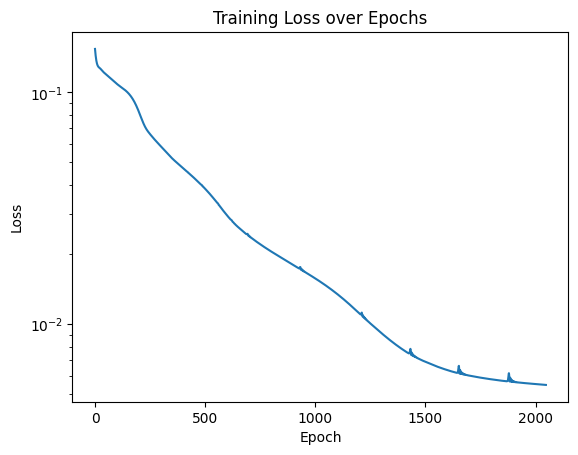

In [18]:
model.trainer(x, t, u_0)
summary(model)

# Prediction


PINN Simulation Parameters

Domain Limits (xmin, xmax): 0 , 6.283185307179586
Domain Length (L): 6.283185307179586
Number of Spatial Points (Nx): 512
Cell Width (dx): 0.012295861657885687

Final Time (Tf): 2.0

Time Step (dt): 0.01
Number of Time Steps (Nt): 201



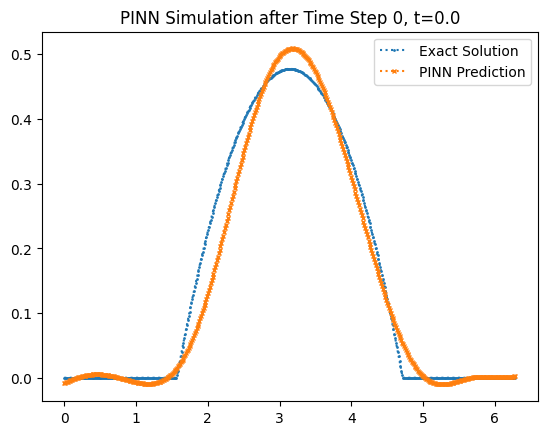

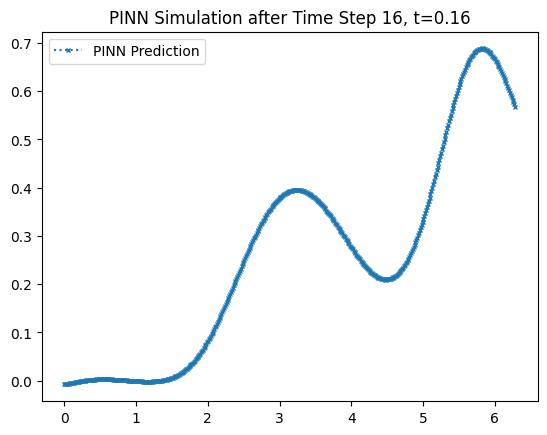

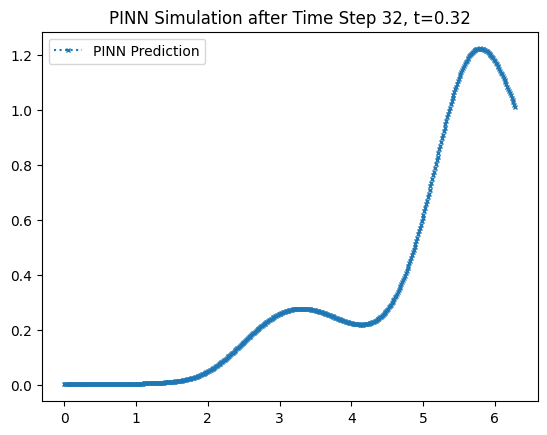

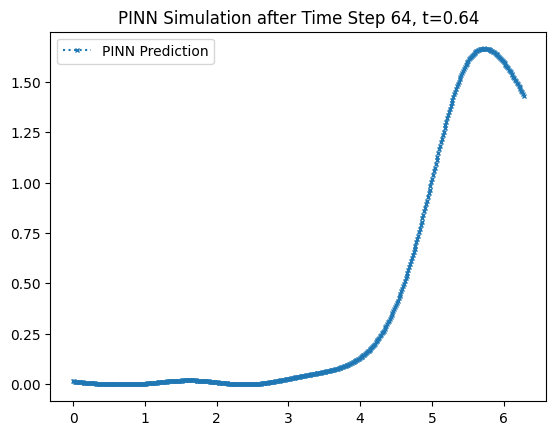

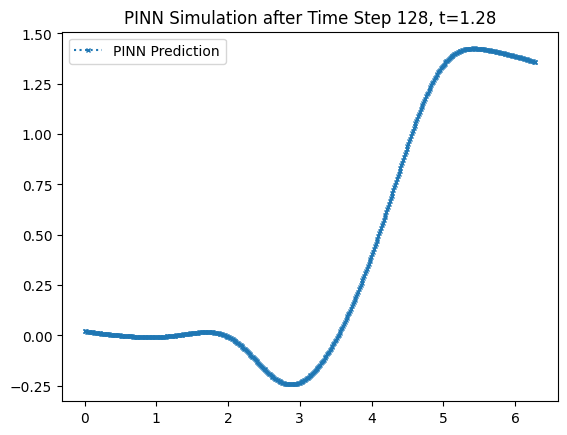

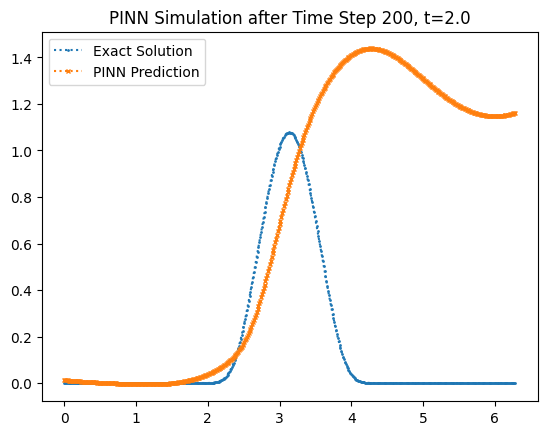

In [19]:
get_param()

model.eval()
with torch.no_grad():
    u_n = model(x, t).reshape(x_mesh.shape)

out_file = open("simulation_data.txt", 'w')
for time_step in range(len(_t)):
    write_data(out_file, u_n[time_step, :].detach().cpu().numpy().flatten())
out_file.close()

plot()

In [20]:
! python -u "steps/gif.py"

Traceback (most recent call last):
  File "d:\Programming\proj\Numerical Sim\code\PINN_Kuramoto\steps\gif.py", line 12, in <module>
    frames[0].save("output.gif", save_all=True, append_images=frames[1:], loop=0, duration=20)
    ~~~~~~^^^
IndexError: list index out of range
